### Feature selection analysis
Select a small subset of genes responsible for the variability in individual anatomical features within transcriptomic type or subclass by solving the Lasso regression problem. 

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.stats import pearsonr
import json
from skimage.measure import block_reduce
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [2]:
rootdir = '../..'
datadir = os.path.join(rootdir, 'data')

# Load transcriptomic data
data_file = os.path.join(datadir, 'dataset', 'tdata.mat')
data = sio.loadmat(data_file, squeeze_me=True)
sp_tdata = list(data['specimen_id'])
gene_id = data['gene_id']

# Load moropholgical data
csv_file = os.path.join(datadir, 'dataset', 'specimens.csv')
df = pd.read_csv(csv_file)
sp_mdata = list(df.specimen_id.values)
idx1 = [sp_tdata.index(l) for l in sp_mdata if l in sp_tdata]
tdata_select = data['tdata'][idx1,:]
idx2 = [sp_mdata.index(l) for l in sp_tdata if l in sp_mdata]
dfm = df.iloc[idx2]
sp_select = np.array(dfm.loc[:,'specimen_id'], dtype=object)
t_type_select = np.array(dfm.loc[:,'VISp Tree Mapping'], dtype=object)
soma_depth_select = np.array(dfm.soma_depth.values, dtype=np.float32)

In [3]:
# Select transcriptomic type
t = 'Sst Calb2 Pdlim5' 
idxt = np.where(t_type_select == t)[0]
kt = len(idxt)
spt = sp_select[idxt]
xt = tdata_select[idxt]

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(xt)
xt_scaled = scaler.transform(xt)

# Create mdata array
rbin_size = 1
zbin_size = 120
block_size = 1, 1 # z, r
hist_size = rbin_size//block_size[1]*zbin_size//block_size[0]*2 # 2 - axon, dendrite, 1-axon only
mdata = np.zeros((kt, hist_size))
for k, sp in enumerate(spt):
    fname = os.path.join(datadir, 'dataset', 'hist1d', 'hist1d_axon_%d.csv'%sp)  
    hist2d = np.loadtxt(fname, delimiter=',')
    hist2d = block_reduce(hist2d.reshape(hist2d.shape[0],-1), block_size, np.sum)
    mdata[k,0:hist_size//2] = hist2d.reshape(1, hist_size//2)
    fname = os.path.join(datadir, 'dataset', 'hist1d', 'hist1d_dendrite_%d.csv'%sp) 
    hist2d = np.loadtxt(fname, delimiter=',')
    hist2d = block_reduce(hist2d.reshape(hist2d.shape[0],-1), block_size, np.sum)
    mdata[k,hist_size//2:] = hist2d.reshape(1, hist_size//2)
mdata1 = mdata[:,0:hist_size//2]
mdata2 = mdata[:,hist_size//2:]   

# Soma depth values
sd = soma_depth_select[idxt]
sd_idx = np.argsort(soma_depth_select[idxt])
sd_up = sd[sd_idx]

# Load average layer depth
layer_depths_file = os.path.join(datadir, 'dataset', 'mouse_me_and_met_avg_layer_depths.json')
with open(layer_depths_file, "r") as f:
    avg_layer_depths = json.load(f)
print(avg_layer_depths)
llist = [l for l in avg_layer_depths.keys()]
layer_bins = [int(np.round(avg_layer_depths[l]/avg_layer_depths[llist[-1]]*100)) for l in llist[:-2]]
nlayers = 5
idx_l = [0, layer_bins[0] + 1, layer_bins[1] + 1, layer_bins[2] + 1, layer_bins[3] + 1, 100]
layer_axon_mass = np.zeros((mdata.shape[0], nlayers))
layer_dendrite_mass = np.zeros((mdata.shape[0], nlayers))
for i in range(nlayers):
    layer_axon_mass[:,i] = np.sum(mdata1[:, idx_l[i]:idx_l[i+1]],1)
    layer_dendrite_mass[:,i] = np.sum(mdata2[:, idx_l[i]:idx_l[i+1]],1)

{'2/3': 115.1112491335, '4': 333.4658190171, '5': 453.6227158132, '6a': 687.6482650269, '6b': 883.1308910545, 'wm': 922.5861720311}


In [4]:
def feature_lassoCV(xt_train, yt_train, gene_id, alphas=None, positive=False):
    model = LassoCV(alphas=alphas, fit_intercept=False, max_iter=10000, cv=5, positive=positive, random_state=0)
    model.fit(xt_train, yt_train)
        
    lasso = Lasso(alpha=model.alpha_, fit_intercept=False, max_iter=10000, positive=positive)
    lasso.fit(xt_train, yt_train)

    select = np.nonzero(lasso.coef_)
    feature_list = [gene_id[i] for i in select[0]]
    return (select[0], feature_list, lasso.coef_[select], model.alpha_)

In [5]:
def score_nmax(xt_train, xt_test, yt_train, yt_test, xt_scaled, yt_scaled, select, coeff, nmax=10):
    # Calculate R^2 using nmax features with largest coeff
    idx = np.flip(np.argsort(abs(coeff))) 
    yt_train_pred = np.matmul(xt_train[:,select[idx[0:nmax]]],coeff[idx[0:nmax]])
    yt_test_pred = np.matmul(xt_test[:,select[idx[0:nmax]]],coeff[idx[0:nmax]])
    yt_scaled_pred = np.matmul(xt_scaled[:,select[idx[0:nmax]]],coeff[idx[0:nmax]])
    train_r2 = r2_score(yt_train, yt_train_pred)
    test_r2 = r2_score(yt_test, yt_test_pred)
    all_r2 = r2_score(yt_scaled, yt_scaled_pred)

    return train_r2, test_r2, all_r2, idx[0:nmax]

In [6]:
def run_cv(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, a1, a2, s):
    shuffled_idx = np.arange(xt_select_scaled.shape[0])
    np.random.seed(s)
    np.random.shuffle(shuffled_idx)
    xt_scaled_shuffled = xt_select_scaled[shuffled_idx,:]
    yt_scaled_shuffled = yt_select_scaled[shuffled_idx]

    # Cross-validation, select alpha using lassoCV
    fold_num = 5
    fold_size = xt_scaled_shuffled.shape[0]//fold_num
    alpha = np.zeros((fold_num,))
    train_r2 = np.zeros((fold_num,))
    test_r2 = np.zeros((fold_num,))
    all_r2 = np.zeros((fold_num,))
    features_all = []
    coeffs_all = []
    for i in range(fold_num):
        # Create train/test split
        test_idx = np.arange(i*fold_size, (i+1)*fold_size)
        train_idx = np.setdiff1d(np.arange(xt_scaled_shuffled.shape[0]),test_idx)
        xt_train = xt_scaled_shuffled[train_idx,:]
        xt_test = xt_scaled_shuffled[test_idx,:]
        yt_train = yt_scaled_shuffled[train_idx]
        yt_test = yt_scaled_shuffled[test_idx]

        # Select alpha, features 
        select_lasso, feature_list_lasso, coeff_lasso, alpha[i] = feature_lassoCV(xt_train, yt_train, gene_id, model_alphas[a1:a2])

        # Calculate R^2 using only features with largest coefficients
        train_r2[i], test_r2[i], all_r2[i], idx_nmax = score_nmax(xt_train, xt_test, yt_train, yt_test, 
                                                xt_scaled_shuffled, yt_scaled_shuffled,
                                                select_lasso, coeff_lasso, nmax=min(len(feature_list_lasso),10))
        features = gene_id[select_lasso[idx_nmax]]
        features_all.append(features)
        coeffs = coeff_lasso[idx_nmax]
        coeffs_all.append(coeffs)
    
    return (alpha, train_r2, test_r2, all_r2, features_all, coeffs_all)

In [7]:
def select_features(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, a1, a2, ns=30):
    arr = np.zeros((ns,))
    output_list = []
    for s in range(ns):
        output = run_cv(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, a1, a2, s)
        output_list.append(output)
        arr[s] = np.mean(output[2])
    s1 = np.argmax(arr)    
    result = output_list[s1]
    print('alphas', result[0], '\ntrain_r2', result[1], '\ntest_r2', result[2], '\nall_r2', result[3])
    train_r2_mean = np.mean(result[1])
    test_r2_mean = np.mean(result[2])
    all_r2_mean = np.mean(result[3])
    print('avg train r2 %f'%train_r2_mean, '\navg test r2 %f'%test_r2_mean, '\navg all r2 %f'%all_r2_mean)
    f_unique, f_num = np.unique(np.concatenate(result[4]),return_counts=True)
    idxf = np.flip(np.argsort(f_num))
    counts = f_num[idxf]
    print('counts', counts)
    features10 = f_unique[idxf[0:10]]
    print('10 features', np.array_str(features10, max_line_width=np.inf))
    features20 = f_unique[idxf[0:20]]
    print('20 features', features20)
    print('all features', f_unique[idxf])
    return result

#### Run sparse regression for L1 axon to select a small subset of genes predicting its variation

In [8]:
# Select feature
nf=0
ext = 'axon'#'axon'#'dendrite'
layer = ['1', '23', '4', '5', '6'][nf]
if ext == 'axon':
    yt = layer_axon_mass[:,nf]
elif ext == 'dendrite':
    yt = layer_dendrite_mass[:,nf]
print('layer%s %s'%(layer, ext))


scaler.fit(yt.reshape(-1,1))
yt_scaled = scaler.transform(yt.reshape(-1,1))
yt_scaled = np.ravel(yt_scaled)

shuffled_idx = np.arange(xt_scaled.shape[0])
np.random.seed(0)
np.random.shuffle(shuffled_idx)
xt_scaled_shuffled = xt_scaled[shuffled_idx,:]
yt_scaled_shuffled = yt_scaled[shuffled_idx]

# Get model_alphas
fold_num = 5
fold_size = xt_scaled.shape[0]//fold_num
for i in range(1):
    test_idx = np.arange(i*fold_size, (i+1)*fold_size)
    train_idx = np.setdiff1d(np.arange(xt_scaled.shape[0]),test_idx)
    xt_train = xt_scaled_shuffled[train_idx,:]
    xt_test = xt_scaled_shuffled[test_idx,:]
    yt_train = yt_scaled_shuffled[train_idx]
    yt_test = yt_scaled_shuffled[test_idx]
    
    model = LassoCV(fit_intercept=False, max_iter=10000, cv=5, positive=False, random_state=0)
    model.fit(xt_train, yt_train)
    model_alphas = model.alphas_

layer1 axon


In [9]:
# Normalize axon/dendrite layer mass
axon_mass = np.sum(mdata1, axis=1)
dendrite_mass = np.sum(mdata2, axis=1)
if ext == 'axon':
    yt_norm = yt/axon_mass
elif ext == 'dendrite':
    yt_norm = yt/dendrite_mass
else:
    print('wrong ext')
    
xt_select = np.copy(xt)
yt_select = np.copy(yt_norm)
scaler.fit(xt_select)
xt_select_scaled = scaler.transform(xt_select)
scaler.fit(yt_select.reshape(-1,1)) # reshape 1d array to 2d array
yt_select_scaled = scaler.transform(yt_select.reshape(-1,1))
yt_select_scaled = np.ravel(yt_select_scaled) 

In [10]:
result = select_features(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, 25, 30)

alphas [0.13852254 0.13852254 0.13852254 0.10478722 0.10478722] 
train_r2 [0.80096806 0.71693927 0.74640789 0.83978781 0.79209005] 
test_r2 [0.58881521 0.31798673 0.46867768 0.17170152 0.45451868] 
all_r2 [0.78547582 0.59364296 0.7096702  0.70829202 0.72571091]
avg train r2 0.779239 
avg test r2 0.400340 
avg all r2 0.704558
counts [5 4 4 4 3 3 3 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10 features ['Cpne7' 'Necab2' 'Crhr2' 'Myh7' 'Metrnl' 'Bcl11b' 'Ptpru' 'Atp2b4' 'Elfn1' 'Tmem163']
20 features ['Cpne7' 'Necab2' 'Crhr2' 'Myh7' 'Metrnl' 'Bcl11b' 'Ptpru' 'Atp2b4'
 'Elfn1' 'Tmem163' 'Trpc4' 'Thrb' 'Pcsk1' 'Ptprt' 'Serpina3n' 'Luzp2'
 'LOC105243542' 'Kcnn2' 'Epha4' 'Slit2']
all features ['Cpne7' 'Necab2' 'Crhr2' 'Myh7' 'Metrnl' 'Bcl11b' 'Ptpru' 'Atp2b4'
 'Elfn1' 'Tmem163' 'Trpc4' 'Thrb' 'Pcsk1' 'Ptprt' 'Serpina3n' 'Luzp2'
 'LOC105243542' 'Kcnn2' 'Epha4' 'Slit2' 'Sstr1' 'Stac' 'Cdh12' 'Bcar3'
 'Thrsp' '1190002N15Rik']


In [11]:
# Save gene list for figure plotting (below)
f_unique, f_num = np.unique(np.concatenate(result[4]),return_counts=True)
idxf = np.flip(np.argsort(f_num))
f20 = f_unique[idxf[0:20]]
print('20 features', f20)

20 features ['Cpne7' 'Necab2' 'Crhr2' 'Myh7' 'Metrnl' 'Bcl11b' 'Ptpru' 'Atp2b4'
 'Elfn1' 'Tmem163' 'Trpc4' 'Thrb' 'Pcsk1' 'Ptprt' 'Serpina3n' 'Luzp2'
 'LOC105243542' 'Kcnn2' 'Epha4' 'Slit2']


#### Calculate p-value by running a non-parametric shuffle test

In [12]:
def shuffled_run(xt_scaled, yt_scaled, gene_id, model_alphas, num=1000):
    train_r2_all = np.zeros(num,)
    test_r2_all = np.zeros(num,)
    all_r2_all = np.zeros(num,)
    features_all = []
    counts_all = []
    shuffled_idx_all = []
    for n in range(num):
        np.random.seed(n)
        shuffled_idx = np.arange(yt_scaled.shape[0])
        np.random.shuffle(shuffled_idx)
        shuffled_idx_all.append(shuffled_idx)
        yt_scaled_shuffled = yt_scaled[shuffled_idx]
    
        fold_num = 5
        fold_size = xt_scaled.shape[0]//fold_num
        alpha = np.zeros((fold_num,))
        train_r2 = np.zeros((fold_num,))
        test_r2 = np.zeros((fold_num,))
        all_r2 = np.zeros((fold_num,))
        features_n = []
        for i in range(fold_num):
            # Create train/test split
            test_idx = np.arange(i*fold_size, (i+1)*fold_size)
            train_idx = np.setdiff1d(np.arange(xt_scaled.shape[0]),test_idx)
            xt_train = xt_scaled[train_idx,:]
            xt_test = xt_scaled[test_idx,:]
            yt_train = yt_scaled_shuffled[train_idx]
            yt_test = yt_scaled_shuffled[test_idx]
            
            # Select alpha, features 
            select_lasso, feature_list_lasso, coeff_lasso, alpha[i] = feature_lassoCV(xt_train, yt_train, gene_id)

            # Calculate R^2 using only features with largest coefficients
            train_r2[i], test_r2[i], all_r2[i], idx_nmax = score_nmax(xt_train, xt_test, yt_train, yt_test,
                                                    xt_scaled, yt_scaled_shuffled,
                                                    select_lasso, coeff_lasso, nmax=min(len(feature_list_lasso),10))
            features = gene_id[select_lasso[idx_nmax]]
            features_n.append(features)
    
        train_r2_all[n] = np.mean(train_r2)
        test_r2_all[n] = np.mean(test_r2)
        all_r2_all[n] = np.mean(all_r2)   
        f_unique, f_num = np.unique(np.concatenate(features_n),return_counts=True)
        idxf = np.flip(np.argsort(f_num))
        features_all.append(f_unique[idxf[0:10]])
        counts_all.append(f_num[idxf])
        
    return train_r2_all, test_r2_all, all_r2_all, features_all, counts_all 

In [13]:
def calculate_pvalue(file1, file2):
    df = pd.read_csv(file1)
    train_r2 = df['train_r2'].values
    test_r2 = df['test_r2'].values
    all_r2 = df['all_r2'].values
    train_r2_mean = [np.mean(train_r2)]
    test_r2_mean = [np.mean(test_r2)]
    all_r2_mean = [np.mean(all_r2)]

    df = pd.read_csv(file2)
    train_r2 = df['train_r2'].values
    test_r2 = df['test_r2'].values
    all_r2 = df['all_r2'].values
    train_r2_mean.append(np.mean(train_r2))
    test_r2_mean.append(np.mean(test_r2))
    all_r2_mean.append(np.mean(all_r2))

    train_p = len(np.where(train_r2 >=train_r2_mean[0])[0])/len(train_r2)
    test_p = len(np.where(test_r2 >=test_r2_mean[0])[0])/len(test_r2)
    all_p = len(np.where(all_r2 >=all_r2_mean[0])[0])/len(all_r2)
    
    return (train_r2_mean[0], test_r2_mean[0], all_r2_mean[0],
         train_r2_mean[1], test_r2_mean[1], all_r2_mean[1],
         train_p, test_p, all_p)  

In [14]:
# For illustration perform only 2 shuffled runs instead of 1000 runs used to calculate p-value
num_shuffle = 2
train_r2_all, test_r2_all, all_r2_all, features_all, counts_all = \
    shuffled_run(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, num=num_shuffle)

print('train_r2_all', train_r2_all, 'test_r2_all', test_r2_all, 'all_r2_all', all_r2_all,
     'features_all', features_all, 'counts_all', counts_all)

train_r2_all [0.25756754 0.05337494] test_r2_all [-0.24507429 -0.0973418 ] all_r2_all [0.18177898 0.02999868] features_all [array(['Synj2', 'Smad3', '6530403H02Rik', 'Ass1', 'Cacna1h', 'Chrna5',
       'Cit', 'Clstn3', 'Gng13', 'Grm2'], dtype=object), array(['Slc27a2', 'Rasgrf2', 'Pxdc1', 'Lrp1b', 'Dock4', 'Adcyap1'],
      dtype=object)] counts_all [array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1])]


In [15]:
# Load original and shuffled (1000 runs) data, calculate p-values   
filename1 = os.path.join(datadir, 'dataset','%s_l%s_axon_norm.csv'%(t.replace(' ', ''),layer))
filename2 = os.path.join(datadir, 'dataset','%s_l%s_axon_norm_shuffled.csv'%(t.replace(' ', ''),layer))

(train_r2_true,test_r2_true,all_r2_true,
     train_r2_shuffled,test_r2_shuffled,all_r2_shuffled,
     train_p,test_p,all_p) = calculate_pvalue(filename1, filename2)
print('avg train r2 %f'%train_r2_true, 'shuffled %f'%train_r2_shuffled, 'p-value %.3f'%train_p,
      '\navg test r2 %f'%test_r2_true, 'shuffled %f'%test_r2_shuffled, 'p-value %.3f'%test_p,
      '\navg all r2 %f'%all_r2_true, 'shuffled %f'%all_r2_shuffled, 'p-value %.3f'%all_p)

avg train r2 0.779239 shuffled 0.264471 p-value 0.005 
avg test r2 0.400340 shuffled -0.183242 p-value 0.000 
avg all r2 0.704558 shuffled 0.209363 p-value 0.001


#### Repeat sparse regression after removing linear contribution of soma depth to L1 axon mass

Pearsons correlation: -0.673
coefficients -1.2904363
intercept 0.8379749
R^2 0.452952


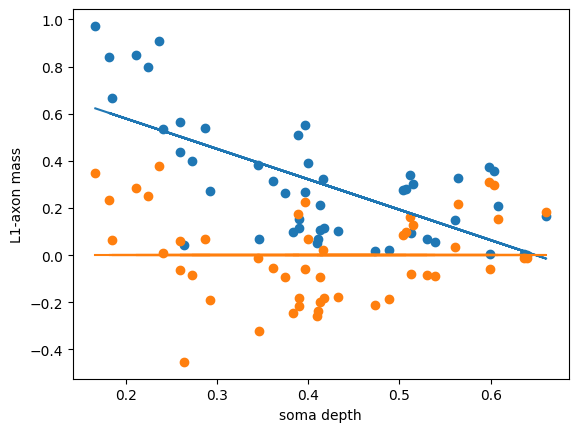

In [16]:
# Calculate correlation between l1 axon norm and soma depth
select = np.where(yt>0)[0]
corr, _ = pearsonr(yt_norm[select], sd[select])
print('Pearsons correlation: %.3f' % corr)

# Calculate slope of the linear fit of l1-axon norm(soma_depth) y = a*x + b (nonzero l1-axon)
select = np.where(yt>0)[0]
lm = LinearRegression(fit_intercept=True)
lm.fit(sd[select].reshape(-1,1),yt_norm[select].reshape(-1,1))
a = lm.coef_[0][0]
b = lm.intercept_[0]
print('coefficients', a)
print('intercept', b)
print('R^2 %f'%lm.score(sd[select].reshape(-1,1),yt_norm[select].reshape(-1,1)))
yt_norm_sd = np.copy(yt_norm)
yt_norm_sd[select] = yt_norm[select] - a*sd[select] - b

plt.figure()
plt.scatter(sd[select], yt_norm[select])
plt.plot(sd[select],a*sd[select]+b)
plt.scatter(sd[select], yt_norm_sd[select])
plt.plot(sd[select], sd[select]*0)
plt.xlabel('soma depth')
plt.ylabel('L1-axon mass')
plt.show()

xt_select = np.copy(xt)
yt_select = np.copy(yt_norm_sd)
scaler.fit(xt_select)
xt_select_scaled = scaler.transform(xt_select)
scaler.fit(yt_select.reshape(-1,1)) # reshape 1d array to 2d array
yt_select_scaled = scaler.transform(yt_select.reshape(-1,1))
yt_select_scaled = np.ravel(yt_select_scaled) 

In [17]:
result = select_features(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, 30, 40, 50)

alphas [0.09772492 0.09772492 0.09772492 0.05215285 0.09772492] 
train_r2 [0.81761106 0.7933508  0.79996732 0.79084376 0.76234755] 
test_r2 [0.48023371 0.03881695 0.49105016 0.15872657 0.4009518 ] 
all_r2 [0.77801571 0.73767897 0.74009536 0.61100923 0.69321373]
avg train r2 0.792824 
avg test r2 0.313956 
avg all r2 0.712003
counts [5 5 4 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10 features ['Slit2' 'Agbl4' 'Tnfaip8l3' 'Necab2' 'Tmem163' 'Kcnt2' 'Arap2' 'Arc' 'Cygb' '1190002N15Rik']
20 features ['Slit2' 'Agbl4' 'Tnfaip8l3' 'Necab2' 'Tmem163' 'Kcnt2' 'Arap2' 'Arc'
 'Cygb' '1190002N15Rik' 'Rgs8' 'Ptpru' 'Myh7' 'Cdh4' 'Rwdd3' 'Rab3b'
 'BC006965' 'Bcar3' 'Cacng5' 'Col24a1']
all features ['Slit2' 'Agbl4' 'Tnfaip8l3' 'Necab2' 'Tmem163' 'Kcnt2' 'Arap2' 'Arc'
 'Cygb' '1190002N15Rik' 'Rgs8' 'Ptpru' 'Myh7' 'Cdh4' 'Rwdd3' 'Rab3b'
 'BC006965' 'Bcar3' 'Cacng5' 'Col24a1' 'Luzp2' 'Dnajb5' 'Gucy2g' 'Ildr2'
 'Optn' 'LOC102635502' 'Lppr1' 'Zdhhc14']


#### Calculate p-value by running a non-parametric shuffle test

In [18]:
# For illustration perform only 2 shuffled runs instead of 1000 runs used to calculate p-value
num_shuffle = 2
train_r2_all, test_r2_all, all_r2_all, features_all, counts_all = \
    shuffled_run(xt_select_scaled, yt_select_scaled, gene_id, model_alphas, num=num_shuffle)

print('train_r2_all', train_r2_all, 'test_r2_all', test_r2_all, 'all_r2_all', all_r2_all,
     'features_all', features_all, 'counts_all', counts_all)

train_r2_all [0.29264619 0.28592977] test_r2_all [-0.19764423 -0.35582347] all_r2_all [0.22804547 0.21862545] features_all [array(['Sox1', 'Dleu7', 'Sphkap', 'Cxxc4', 'Egfem1', 'Flt3', 'Glra3',
       'Grik3', 'Hrk', 'Il11ra1'], dtype=object), array(['Cap2', 'Cdyl2', 'Pcp4l1', 'Masp1', 'Unc5d', 'Gng13', 'Car7',
       'Dock4', 'Eya4', 'Frmpd1'], dtype=object)] counts_all [array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


In [19]:
# Load original and shuffled (1000 runs) data, calculate p-values   
filename1 = os.path.join(datadir, 'dataset','%s_l%s_axon_norm_sd.csv'%(t.replace(' ', ''),layer))
filename2 = os.path.join(datadir, 'dataset','%s_l%s_axon_norm_sd_shuffled.csv'%(t.replace(' ', ''),layer))

(train_r2_true,test_r2_true,all_r2_true,
     train_r2_shuffled,test_r2_shuffled,all_r2_shuffled,
     train_p,test_p,all_p) = calculate_pvalue(filename1, filename2)
print('avg train r2 %f'%train_r2_true, 'shuffled %f'%train_r2_shuffled, 'p-value %.3f'%train_p,
      '\navg test r2 %f'%test_r2_true, 'shuffled %f'%test_r2_shuffled, 'p-value %.3f'%test_p,
      '\navg all r2 %f'%all_r2_true, 'shuffled %f'%all_r2_shuffled, 'p-value %.3f'%all_p)

avg train r2 0.792824 shuffled 0.252500 p-value 0.000 
avg test r2 0.313956 shuffled -0.142606 p-value 0.000 
avg all r2 0.712003 shuffled 0.202075 p-value 0.000


#### Generate figure

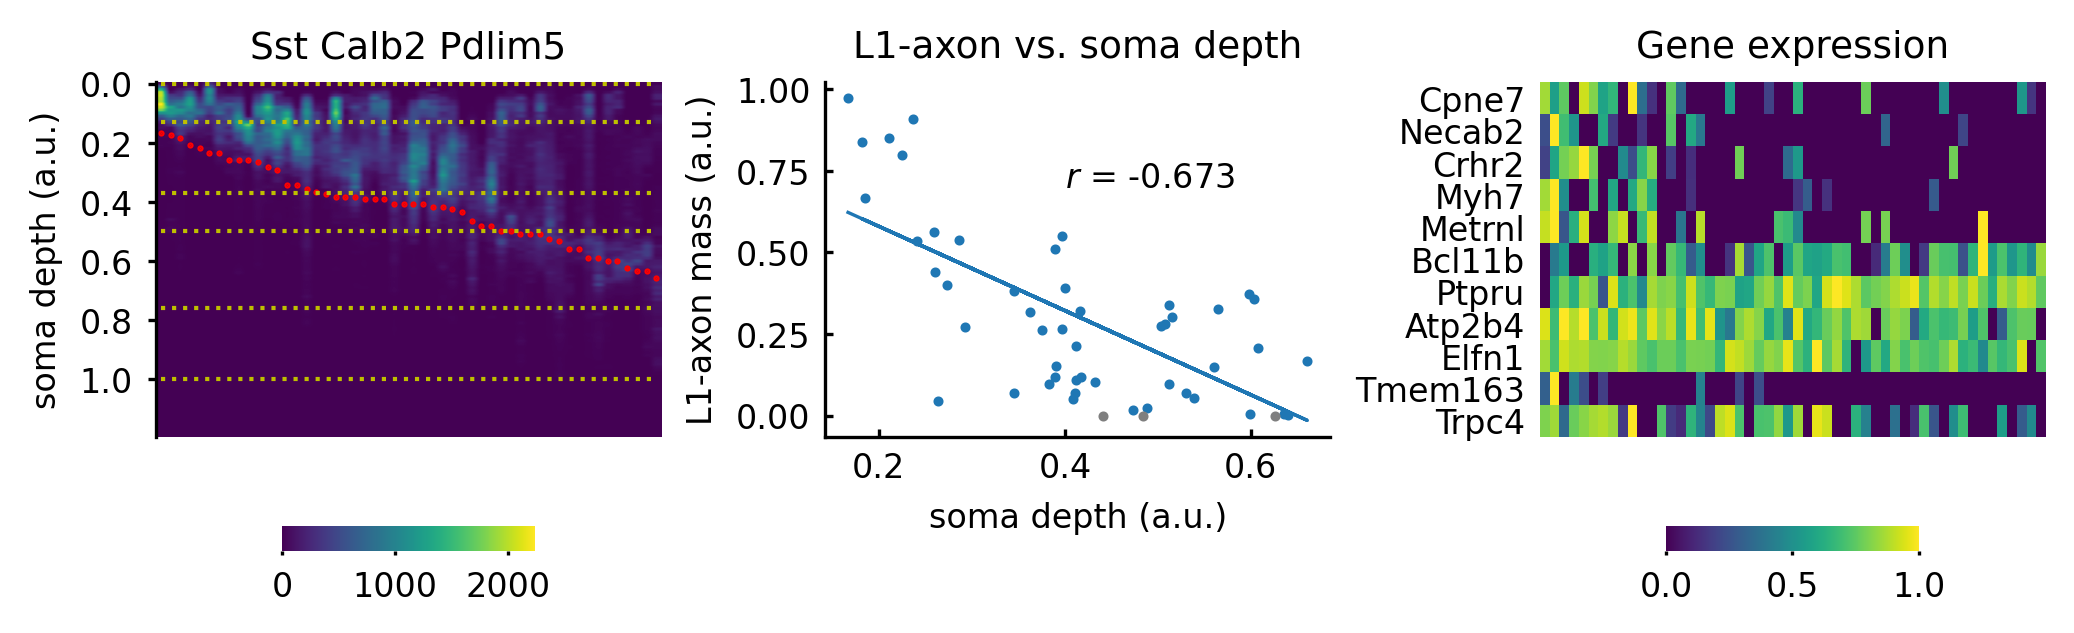

In [23]:
yt_norm_idx = np.argsort(yt_norm)
yt_idx = np.argsort(yt)
idx20 = np.zeros((20,), dtype=int)
for i, f in enumerate(f20):
    idx20[i] = np.where(gene_id==f)[0][0]
arr = np.transpose(xt[yt_norm_idx,:][:,idx20[0:11]])
arr_norm = np.zeros((arr.shape))
for i in range(arr_norm.shape[0]):
    arr_norm[i,:] = (arr[i,:] - np.min(arr[i,:]))/(np.max(arr[i,:]) - np.min(arr[i,:]))

fig = plt.figure(figsize=(6.8,2), constrained_layout=True, dpi=300)
widths = [1, 1, 1]
heights = [1]
plt.rcParams['font.size'] = '8'
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
p1 = ax1.imshow(np.transpose(mdata1[sd_idx]))
cb1 = fig.colorbar(p1, ax=ax1, aspect=10, pad=-0.02, shrink=0.5, location='bottom', ticks=[0,1000,2000])
cb1.outline.set_visible(False)
cb1.ax.tick_params(size=1)
ax1.scatter(range(mdata1.shape[0]), sd_up*hist_size//2/1.2 ,marker = '.', c='r', s=1) # 120 -> 1.2
ax1.hlines(idx_l, 0, kt-1, colors='y', linestyles='dotted', linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(length=2)
ax1.set_xticks([])
ax1.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.axis('auto')
ax1.set_ylabel('soma depth (a.u.)')
ax1.set_title('%s'%t, fontsize=9)

ax2 = fig.add_subplot(spec[0, 1])
ax2.scatter(sd[yt_idx][3:], yt_norm[yt_idx][3:], marker = 'o', s=2)
ax2.scatter(sd[yt_idx][0:3], yt_norm[yt_idx][0:3], marker = 'o', s=2, c='tab:gray')
ax2.plot(sd[select],a*sd[select]+b, linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(direction='in', length=2)
ax2.set_xlabel('soma depth (a.u.)')
ax2.set_ylabel('L1-axon mass (a.u.)')
ax2.set_title("L1-axon vs. soma depth", fontsize=9)
ax2.text(0.4, 0.7, '$\it{r}$ = -0.673')

ax3 = fig.add_subplot(spec[0, 2])
p3 = ax3.imshow(np.flip(arr_norm,1))
cb3 = fig.colorbar(p3, ax=ax3, aspect=10, pad=-0.02, shrink=0.5, location='bottom', ticks=[0,0.5,1])
cb3.outline.set_visible(False)
cb3.ax.tick_params(size=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(length=0)
ax3.set_xticks([])
ax3.set_yticks(range(len(idx20[0:11])))
ax3.set_yticklabels(gene_id[idx20[0:11]], fontname='sans-serif')
ax3.axis('auto')
ax3.set_title("Gene expression", fontsize=9)
plt.show()